<a href="https://www.kaggle.com/code/arsan5623/lontara-character-recognition-cnn-bilstm?scriptVersionId=266378560" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h2 style="color:#1abc9c;">Environment Setup and Library Installation</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Installing all necessary dependencies and preparing the environment for model execution.
</p>

In [1]:
!pip install -q tf2onnx onnxruntime
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
import tf2onnx
import numpy as np
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Bidirectional, Reshape, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 8.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 91.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


<h2 style="color:#1abc9c;">Set up Dataset Path and Parameters</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Loading the Lontara character dataset, defining image dimensions, normalizing data, and splitting it into training and testing sets.
</p>

In [2]:
DATASET_PATH = "/kaggle/input/aksara-lontara/aksara-lontara-fix"

# Param
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = len(os.listdir(DATASET_PATH))  

X = []
y = []
label_map = {}

for idx, label in enumerate(os.listdir(DATASET_PATH)):
    label_map[label] = idx  
    folder_path = os.path.join(DATASET_PATH, label)
    
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  
        img = img / 255.0  
        
        X.append(img)
        y.append(idx)

X = np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)  
y = to_categorical(y, num_classes=NUM_CLASSES)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total data: {len(X)}, Train: {len(X_train)}, Test: {len(X_test)}")


Total data: 11483, Train: 9186, Test: 2297


<h2 style="color:#1abc9c;">Data Augmentation and Visualization</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Applying data augmentation techniques such as shifting, zooming, and rotation to increase dataset diversity and visualizing the augmented samples.
</p>

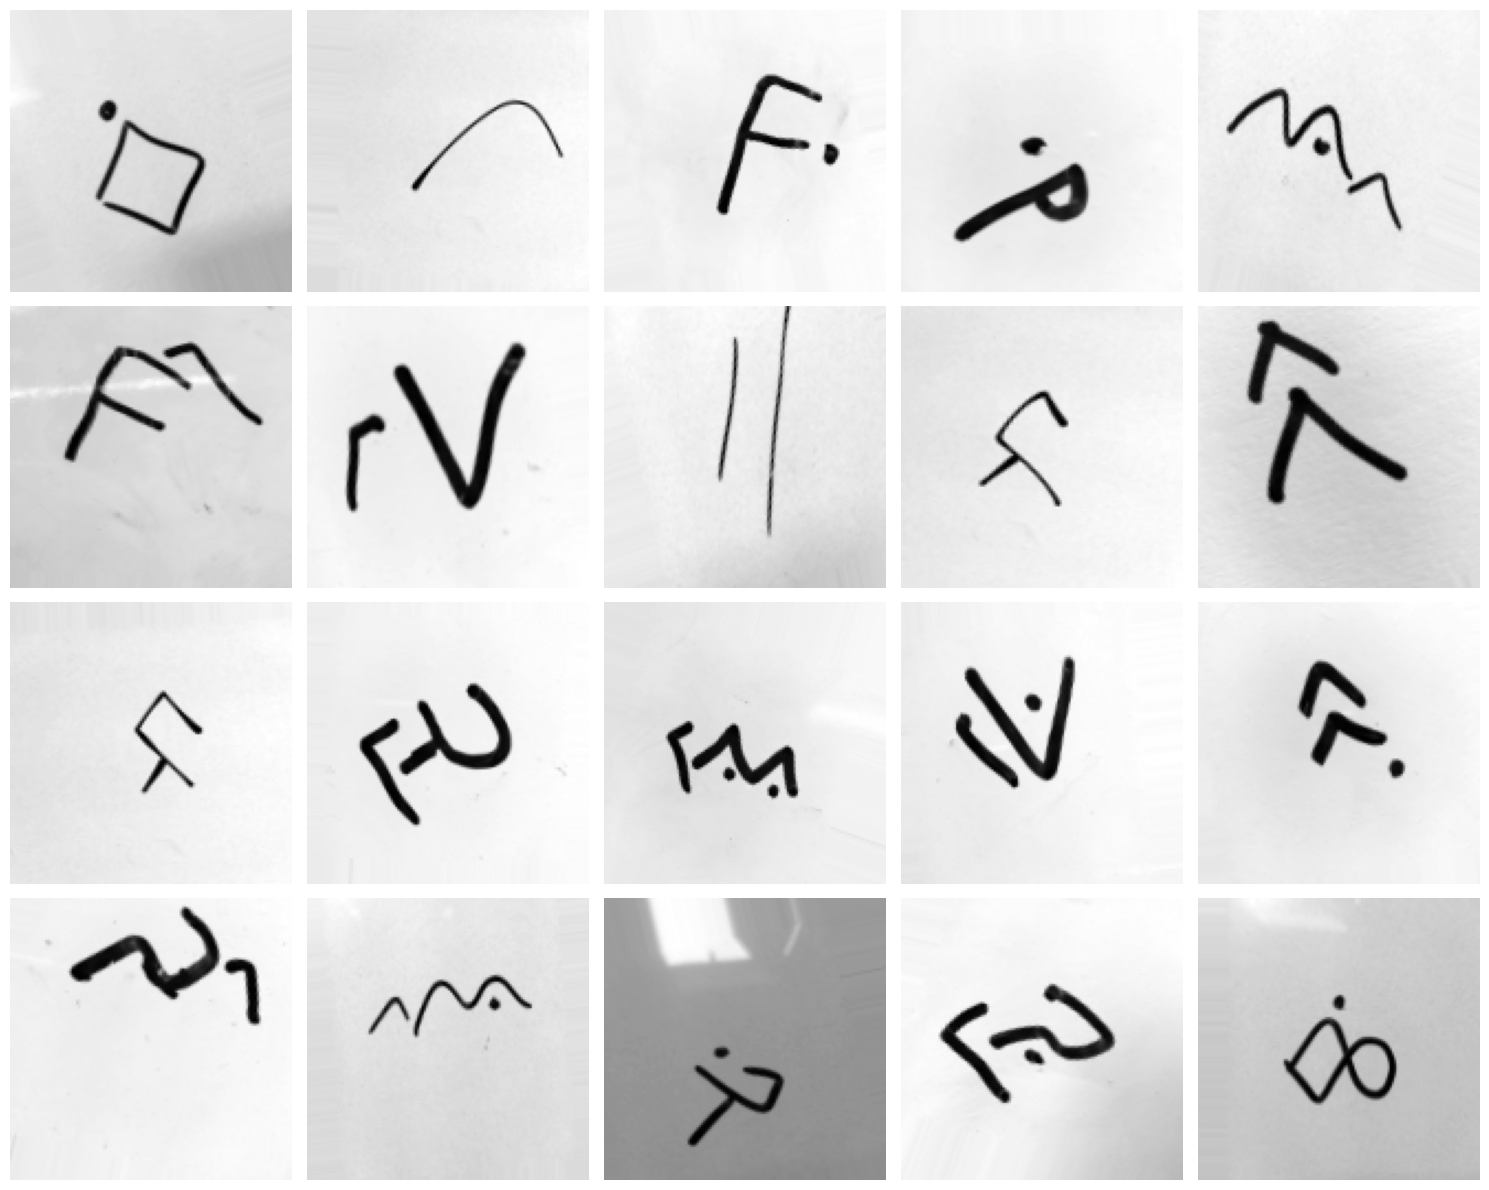

In [3]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    zoom_range=0.2,           
    rotation_range=20,        
    fill_mode='nearest'       
)

num_rows = 4 
num_cols = 5  
num_images = num_rows * num_cols 
batch_size = num_images  

X_augmented, y_augmented = next(train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j  
        axes[i, j].imshow(X_augmented[idx].squeeze(), cmap="gray")  
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

<h2 style="color:#1abc9c;">Build CNN-BiLSTM Model Architecture</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Constructing a hybrid deep learning model combining Convolutional Neural Networks (CNN).
</p>

In [4]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

TIME_STEPS = 16
FEATURES_PER_STEP = x.shape[1] // TIME_STEPS  
x = Reshape((TIME_STEPS, FEATURES_PER_STEP))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │       1,081,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 114)                 │          14,706 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,189,234 (4.54 MB)

 Trainable params: 1,189,234 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

<h2 style="color:#1abc9c;">Train the CNN-BiLSTM Model</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Training the hybrid CNN-BiLSTM model using augmented image data with validation, optimizing weights through 100 epochs to improve classification accuracy.
</p>


In [5]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=100,
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.0089 - loss: 4.6974 - val_accuracy: 0.0636 - val_loss: 4.0366
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.0627 - loss: 3.8854 - val_accuracy: 0.1493 - val_loss: 3.5706
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.1690 - loss: 3.3130 - val_accuracy: 0.2721 - val_loss: 2.9036
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.3751 - loss: 2.5253 - val_accuracy: 0.4702 - val_loss: 2.0514
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.5193 - loss: 1.9267 - val_accuracy: 0.4824 - val_loss: 1.8934
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6456 - loss: 1.4683 - val_accuracy: 0.6008 - val_loss: 1.4486
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7405 - loss: 1.1197 - val_accuracy: 0.7031 - val_loss: 1.0777
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7750 - loss: 0.9223 - val_

<h2 style="color:#1abc9c;">Save the Trained Model</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Saving the trained CNN-BiLSTM model in Keras format for future inference or deployment.
</p>


In [6]:
model.save("cnnBiLstm.keras")

<h2 style="color:#1abc9c;">Model Evaluation and Loss Visualization</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Generating model predictions and visualizing the training and validation loss curve to assess model performance over epochs.
</p>

In [7]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.savefig("loss_curve.png", dpi=300)
plt.close()


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


<h2 style="color:#1abc9c;">Accuracy Trend Visualization</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Plotting the training and validation accuracy curves to observe how the model’s performance improves and stabilizes over epochs.
</p>


In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.savefig("accuracy_curve.png", dpi=300)
plt.close()

<h2 style="color:#1abc9c;">Confusion Matrix Visualization</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Visualizing the confusion matrix for the top 20 classes to analyze model performance and identify class-level prediction patterns.
</p>


In [9]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
top_classes = np.argsort(np.sum(cm, axis=1))[-20:]  
cm_subset = cm[np.ix_(top_classes, top_classes)]
sns.heatmap(cm_subset, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (20 Kelas Teratas)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("confusion_matrix.png", dpi=300)
plt.close()

<h2 style="color:#1abc9c;">ROC Curve Analysis for Selected Classes</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Plotting ROC curves for five selected classes to evaluate the model’s ability to distinguish between true positives and false positives across different thresholds.
</p>


In [10]:
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

selected_classes = np.linspace(0, n_classes - 1, 5, dtype=int)  

for i in selected_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (5 Kelas Terpilih)')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png", dpi=300)
plt.close()

<h2 style="color:#1abc9c;">Class-wise Performance and Inference Evaluation</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Analyzing precision, recall, and F1-score across classes to highlight the best and worst performing categories, followed by measuring the model’s inference speed on a single sample.
</p>

In [11]:
class_report = classification_report(y_test_classes, y_pred_classes, output_dict=True)
class_df = pd.DataFrame(class_report).transpose()
class_df = class_df.iloc[:-3]  

best_classes = class_df.nlargest(5, 'f1-score')
worst_classes = class_df.nsmallest(5, 'f1-score')
selected_classes = pd.concat([best_classes, worst_classes])

sns.heatmap(selected_classes[['precision', 'recall', 'f1-score']], annot=True, cmap='YlGnBu')
plt.title('Performa Terbaik & Terburuk Per Kelas')
plt.savefig("class_performance.png", dpi=300)
plt.close()

start_time = time.time()
_ = model.predict(X_test[0:1])
inference_time = time.time() - start_time

print("\nModel Performance Metrics:")
print("-" * 50)
print(classification_report(y_test_classes, y_pred_classes))
print(f"\nInference time for one sample: {inference_time:.4f} seconds")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

Model Performance Metrics:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        26
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        18
          11       0.91      1.00      0.95        29
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        16
          14       1.00      1.00      1.00        25
          15     

<Figure size 640x480 with 0 Axes>

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9912 - loss: 0.0319
Test Accuracy: 98.96%


<h2 style="color:#1abc9c;">Save Trained Model</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Saving the trained Lontara character recognition model in HDF5 format for future inference and deployment.
</p>

In [13]:
model.save("/kaggle/working/lontara_model.h5")
print("Model saved successfully!")

Model saved successfully!


<h2 style="color:#1abc9c;">Single Sample Prediction Visualization</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Displaying a random test image along with its predicted and actual labels to visually assess the model’s classification accuracy.
</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


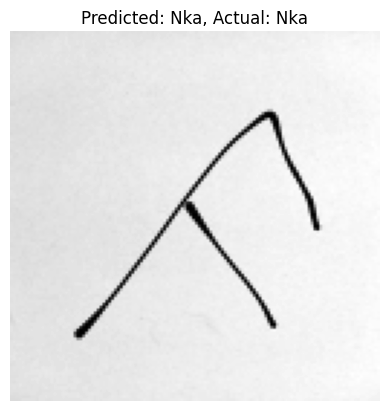

In [14]:
idx = np.random.randint(0, len(X_test))
img_sample = X_test[idx]
label_actual = np.argmax(y_test[idx])

img_sample_input = np.expand_dims(img_sample, axis=0)  # Tambahkan batch dimensi
pred = model.predict(img_sample_input)
label_pred = np.argmax(pred)

plt.imshow(img_sample.reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
plt.title(f"Predicted: {list(label_map.keys())[label_pred]}, Actual: {list(label_map.keys())[label_actual]}")
plt.axis('off')
plt.show()

<h2 style="color:#1abc9c;">Sequential Character Prediction Using Sliding Window</h2>
<p style="background-color:#e8f8f5; border-left:6px solid #1abc9c; padding:10px; border-radius:8px;">
Combining multiple Lontara characters into a single image and applying a sliding window approach to predict each character sequentially, demonstrating the model’s ability to read connected script patterns.
</p>

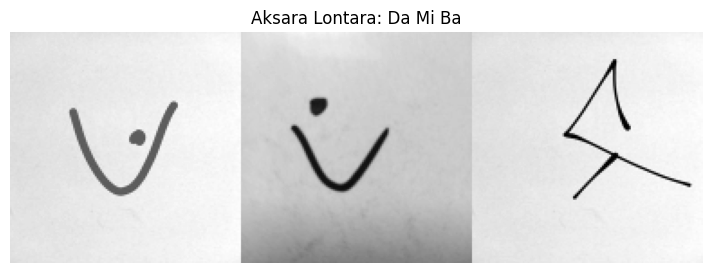


Hasil Prediksi:
Target    : Da Mi Ba
Prediksi  : Da Mi Ba


In [15]:
import cv2
import numpy as np

def get_image_by_label(X_test, y_test, target_label):
    label_indices = np.where(np.argmax(y_test, axis=1) == label_map[target_label])[0]
    selected_idx = np.random.choice(label_indices)
    return X_test[selected_idx]

desired_word = ['Da', 'Mi', 'Ba'] 

selected_images = []
for label in desired_word:
    img = get_image_by_label(X_test, y_test, label)
    selected_images.append(img)

combined_image = np.hstack([img.reshape(IMG_HEIGHT, IMG_WIDTH) for img in selected_images])

plt.figure(figsize=(12,3))
plt.imshow(combined_image, cmap='gray')
plt.title(f"Aksara Lontara: {' '.join(desired_word)}")
plt.axis('off')
plt.show()

def sliding_window_predict(image, model, window_width=IMG_WIDTH, stride=IMG_WIDTH):
    predictions = []
    for start_x in range(0, image.shape[1] - window_width + 1, stride):
        window = image[:, start_x:start_x + window_width]
        window = np.expand_dims(window, axis=(0, -1))
        pred = model.predict(window, verbose=0)  
        char_idx = np.argmax(pred)
        predictions.append(list(label_map.keys())[char_idx])
    return predictions

predicted_chars = sliding_window_predict(combined_image, model)
print("\nHasil Prediksi:")
print(f"Target    : {' '.join(desired_word)}")
print(f"Prediksi  : {' '.join(predicted_chars)}")